In [2]:
import os
import string
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score , roc_curve

import nltk
from nltk import word_tokenize, re
from nltk.stem import PorterStemmer as Stemmer
from nltk.stem.wordnet import WordNetLemmatizer as Lemmatizer

import matplotlib.pyplot as plt
import matplotlib.style as style

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

from pathlib import Path
from textblob import Word, TextBlob
from xgboost import XGBClassifier


from IPython.display import display


In [3]:
# Global Values 
READED_FILE = "/kaggle/input/newparseddata/parsed_files8.txt"
PATH = 'txt_sentoken'
STEMMER = Stemmer()
LEMMATIZER = Lemmatizer()
VECTOR_SIZE=100

In [4]:
# A PART FUNCTIONS

# UTILITIES FUNCTIONS
def nested_to_dataframe(text_list):
    df = pd.DataFrame(columns=['Text'])
    index = 0
    for text in text_list:
        df.loc[index] = ' '.join(text)
        index += 1
    return df

# READER FUNCTIONS
def read_file():
    words = []
    file = open(READED_FILE, 'r')
    for text_line in file.readlines():
        temp = text_line.split(',')
        temp[-1] = temp[-1][0:-1]
        words.append(temp)
    file.close()
    return words



# WRITER FUNCTIONS
def write_to_file(text_files):
    file = open("parsed_files7.txt", "w")
    for text_list in text_files:
        file.write(','.join(text_list))
        file.write('\n')
    print('File is created.\n')


def write_to_text(text_list):
    file = open("parsed.txt", "w")
    file.write(','.join(text_list))
    print('File is created.\n')


# FUNCTIONS
def read_data():
    files_text = []
    for p in Path(PATH).glob('**/*.txt'):
        files_text.append(p.read_text())
    return files_text

# TOKENIZATION
def tokenize_words(files_text):
    index = 0
    for text in files_text:
        files_text[index] = word_tokenize(text)
        index += 1
    return files_text

# REMOVE STOPWORDS
def remove_stopwords(text_list):
    stopword = nltk.corpus.stopwords.words('english')
    stopword.append("'s")
    index = 0
    for text in text_list:
        text_list[index] = [word for word in text if word not in stopword]
        index += 1
    return text_list

# STEMMING
def stemming(text_list):
    return_list = []
    for text in text_list:
        temp_word_list = []
        for word in text:
            if word:
                temp_word_list.append(STEMMER.stem(word))
        return_list.append(temp_word_list)
    return return_list

# LEMMATIZATION
def lemmatization(text_list, pos):
    return_list = []
    for text in text_list:
        temp_word_list = []
        for word in text:
            if word:
                temp_word_list.append(LEMMATIZER.lemmatize(word, pos=pos))
        return_list.append(temp_word_list)

    return return_list

# REMOVE PUNCTUATION
def remove_punctuation(text_list):
    return_list = []
    for text in text_list:
        for remove in string.punctuation:
            text = text.replace(remove, ' ')
        return_list.append(text)
    return return_list

# REMOVE DUPLICATE LETTERS
def remove_duplicate_letters(text_files):
    return_list = []
    for text in text_files:
        inner_list = []
        for word in text:
            rx = re.compile(r'([^\W\d_])\1{2,}')
            word = re.sub(r'[^\W\d_]+',
                          lambda x: Word(rx.sub(r'\1', x.group())).correct() if rx.search(x.group()) else x.group(),
                          word)
            inner_list.append(word)
        return_list.append(inner_list)
    return return_list



In [5]:
# B.1 PART FUNCTIONS

###################################################
#                WORD COUNT
###################################################
def get_word_count(word_list, count, type):
    words_dict = dict()
    for word in word_list:
        if word in words_dict:
            words_dict[word] += 1
        else:
             words_dict[word] = 1
    dataset = pd.DataFrame(words_dict.items(), columns=['Word', 'Count'])
    dataset.sort_values(by=['Count'], inplace=True, ascending=False)
    dataset = dataset.reset_index(drop=True)
    # dataset.head(10).plot(x="Word", y="Length", kind="bar")
#     if type == 'h':
#         print(dataset.head(count).to_string())
#     else:
#         print(dataset.tail(count).to_string())
    
    return(dataset.loc[0])


###################################################
#                LONGEST WORDS
###################################################

def longest_word(words_list, count = 1):
    words_dict = dict()
    for word in words_list:
        words_dict[word] = len(word)
    dataset = pd.DataFrame(words_dict.items(), columns=['Word', 'Length'])
    dataset.sort_values(by=['Length'], inplace=True, ascending=False)
    dataset= dataset.reset_index(drop=True)
    # dataset.head(10).plot(x="Word", y="Length", kind="bar")
    return dataset.loc[0]

def get_longest_words(words_list):
    df = pd.DataFrame(columns = ['Word','Length'])
    index = 0
    for words in words_list:
        df.loc[index]= longest_word(words)
        index += 1
    df.sort_values(by=['Length'], inplace=True, ascending=False)
    return df

###################################################
#             WORD LENGTH
###################################################

def print_word_length(word_list, count, type):
    words_dict = dict()
    for word in word_list:
        words_dict[word] = len(word)
    dataset = pd.DataFrame(words_dict.items(), columns=['Word', 'Length'])
    dataset.sort_values(by=['Length'], inplace=True, ascending=False)
    dataset = dataset.reset_index(drop=True)
    if type == 'h':
        print(dataset.head(count).to_string())
    else:
        print(dataset.tail(count).to_string())
    return dataset

###################################################
#                4 DIGIT DATE COUNT
###################################################

def get_dates_in_word(word_list, count, type):
    words_dict = dict()
    for word in word_list:
        if word.isdigit() and len(word) == 4:
            if word in words_dict:
                words_dict[word] += 1
            else:
                words_dict[word] = 1
    dataset = pd.DataFrame(words_dict.items(), columns=['Word', 'Count'])
    dataset.sort_values(by=['Count'], inplace=True, ascending=False)
    dataset = dataset.reset_index(drop=True)
#     if type == 'h':
#         print(dataset.head(count).to_string())
#     else:
#         print(dataset.tail(count).to_string())
    if not dataset.empty:
        return dataset.loc[0]


###################################################
#            SUBJECTIVITY
###################################################
def print_subjectivity(text_list, count=10, type='h'):
    df = nested_to_dataframe(text_list)
    df['Subjectivity'] = df['Text'].apply(lambda x: TextBlob(str(x)).
                                          sentiment.subjectivity)
    df.sort_values(by=['Subjectivity'], inplace=True, ascending=False)
    if type == 'h':
        print(df.head(count))
    else:
        print(df.tail(count))





In [6]:
# B.2 PART FUNCTIONS

###################################################
#             BAG OF WORDS
###################################################
def BoW(words_list, max_fea = 10):
    bag_of_words_model = CountVectorizer(max_features=max_fea)
    bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform([' '.join(word) for word in words_list]).
                                  todense())
    bag_of_word_df.columns = sorted(bag_of_words_model.vocabulary_)
    return [bag_of_words_model,bag_of_word_df]

###################################################
#             TF IDF
###################################################
def tf_idf(words_list,max_fea = 10):
    words_list = read_file()
    tfidf_model = TfidfVectorizer(max_features=max_fea)
    tfidf_df = pd.DataFrame(tfidf_model.fit_transform([' '.join(word) for word in words_list]).
                            todense())
    tfidf_df.columns = sorted(tfidf_model.vocabulary_)
    return [tfidf_model , tfidf_df]


In [7]:
# B.3 PART FUNCTIONS

###################################################
#             WORD CLOUD
###################################################
def show_word_cloud(words_list,file_number):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          max_words=50,
                          min_font_size=10).generate(' '.join(words_list[file_number]))
    plt.figure(figsize=(15,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


In [8]:
# B.4 PART FUNCTIONS

###################################################
#                LINEAR REG
###################################################
def lin_reg(model_df,words_list):
    df = nested_to_dataframe(words_list)
    df['Target'] = [0 for x in range(0, 1000)] + [1 for x in range(0, 1000)]
    linreg = LinearRegression()
    linreg.fit(model_df, df['Target'])
    predicted_datas = linreg.predict(model_df)
    
    predicted_classes = []
    for i in predicted_datas:
        if i < 0.5:
            predicted_classes.append(0)
        else:
            predicted_classes.append(1)
    
    df['predicted'] = predicted_classes
    df['predicted_datas'] = predicted_datas
    
    return [df, linreg]

###################################################
#             LOGISTIC REG
###################################################
def log_reg(model_df,words_list):
    df = nested_to_dataframe(words_list)
    df['Target'] = [0 for x in range(0, 1000)] + [1 for x in range(0, 1000)]
    # print(df['Target'].value_counts())
    logreg = LogisticRegression()
    logreg.fit(model_df, df['Target'])
    predicted_labels = logreg.predict(model_df)
    # print(logreg.predict_proba(tfidf_df)[:, 1])
    df['predicted'] = predicted_labels
    # print(pd.crosstab(df['Target'], df['Predicted Labels']))
    return [df ,logreg] 

###################################################
#             ELBOW
###################################################
def plot_elbow(model_df,max_cluster):
    distortions = []
    K = range(1, max_cluster+1)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(model_df)
        distortions.append(sum(np.min(cdist(model_df, kmeanModel.cluster_centers_, 'euclidean'),axis = 1)) / model_df.shape[0])
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal number of clusters')
    plt.show()

###################################################
#             k MEANS
###################################################
def k_means(model_df,cluster_number):
    df = nested_to_dataframe(words_list)
    df['Target'] = [0 for x in range(0, 1000)] + [1 for x in range(0, 1000)]
    kmeans = KMeans(n_clusters= cluster_number)
    kmeans.fit(model_df)
    y_kmeans = kmeans.predict(model_df)
    df['predicted'] = y_kmeans
#     print(df.head(20))
    return [df, kmeans] 

###################################################
#          TREE METHOD             
###################################################
# CREATE CLF MODEL
def clf_model(model_type, X_train, y):
    model = model_type.fit(X_train,y)
    predicted_labels = model.predict(tfidf_df)
    return predicted_labels

# CREATE XGB
def XGB(model_df,words_list):
    df = nested_to_dataframe(words_list)
    df['Target'] = [0 for x in range(0, 1000)] + [1 for x in range(0, 1000)]
    xgb_clf=XGBClassifier(n_estimators=20,learning_rate=0.03,max_depth=5,subsample=0.6,colsample_bytree= 0.6,reg_alpha= 10,seed=42)
    df['predicted'] = clf_model(xgb_clf, model_df, df['Target'])
    pd.crosstab(df['Target'], df['predicted'])
    return [df , xgb_clf]

# CREATE DTC
def DTC(model_df,words_list):
    df = nested_to_dataframe(words_list)
    df['Target'] = [0 for x in range(0, 1000)] + [1 for x in range(0, 1000)]
    dtc = tree.DecisionTreeClassifier()
    dtc = dtc.fit(model_df, df['Target'])
    df['predicted'] = dtc.predict(tfidf_df)
    return [df, dtc]



######################################
#         SHOWING RESULTS            #
######################################

# SHOW ACCURACY
def show_accuracy(tab):
    accuracy = (tab.iloc[0,0] + tab.iloc[1,1]) / tab.to_numpy().sum()
    print(f'Accuracy : %{(accuracy * 100):.2f}')

# PRECISION    
def get_pre(tab):
    pre = tab.iloc[1,1] / (tab.iloc[1,1] + tab.iloc[0,1])
    return pre 

# RECALL
def get_rec(tab):
    rec = tab.iloc[1,1] / (tab.iloc[1,1] + tab.iloc[1,0])
    return rec

# SHOW PRECISION
def show_pre(tab):
    print(f'Precision: {get_pre(tab):.2f}')

# SHOW F1 SCORE
def show_f1_score(tab):
    pre = get_pre(tab)
    rec = get_rec(tab)
    f1_score = 2 *  pre * rec / (rec + pre)
    print(f'F1 Score : {f1_score:.2f}') 

# PLOT ROC CURVE
def plot_roc(df_test,ml_model, numeric_df):
    y_pred_proba = ml_model.predict(numeric_df)
    fpr, tpr, _ = roc_curve(df_test['Target'],  y_pred_proba)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# PLOT ROC 
def plot_roc_lor(df_test,ml_model, numeric_df): #TODO
    y_pred_proba = ml_model.predict_proba(numeric_df)[::,1]
    fpr, tpr, _ = roc_curve(df_test['Target'],  y_pred_proba)
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# GET ROOT MEAN SQUARED ERROR
def get_rmse(df):
    rmse = mean_squared_error(df['Target'], df['predicted'], squared=False)
    return rmse

# SHOW ROOT MEN SQUARED ERROR
def show_rmse(df):
    rmse = get_rmse(df)
    print(f'Root Mean Squared Error : {rmse:.2f}') 

In [9]:
# PART C

# GET DICT AND CORPUS VALUES
def get_corpus(words_list):
    dictionary = gensim.corpora.Dictionary(words_list)
    corpus = [dictionary.doc2bow(text) for text in words_list]
    return [dictionary , corpus]

# GET LDA MODEL
def lda(corpus,words_list,dictionary):
    lda_model = LdaModel(corpus, num_topics=VECTOR_SIZE, passes=4)
    arr = []
    for words in words_list:
        arr += words
    bag_of_words = dictionary.doc2bow(arr)
    df = pd.DataFrame(lda_model[bag_of_words] , columns=['Topic','Relevance']).set_index('Topic')
    return [lda_model , df]

# SHOW LDA TOPICS
def show_topics_lda(words_list,topic_number,word_number):
    dictionary = corpora.Dictionary(words_list)
    corpus = [dictionary.doc2bow(text) for text in words_list]
    ldamodel = LdaModel(corpus, num_topics = topic_number, id2word=dictionary, passes=15)
    topics = ldamodel.show_topics(num_words=word_number)
    
    #Create empty matrix
    list_topics = []
    for i in range(topic_number): # For 3 topics => (1x3)matrix
        list_topics.append([])
    
    index = 0
    for topic in topics:
        for topic_word in (topic[1].split('"')):
            if topic_word.isalpha():
                list_topics[index].append(topic_word)
        index +=1
    for topic_list in list_topics:
        print(topic_list)
        
    return list_topics

# SHOW K_MEANS TOPICS
def show_topics_kmeans(model,model_df,topic_number,word_number):
    kmeans = MiniBatchKMeans(n_clusters = topic_number)
    kmeans.fit(model_df)
    centers = kmeans.cluster_centers_.argsort()[:,::-1]
    terms = model.get_feature_names_out()
    words_list = []
    for i in range(0,topic_number):
        word_list=[]
        for j in centers[i,:word_number]:
            word_list.append(terms[j])
        print(word_list) 
        words_list.append(word_list)
    return words_list


In [10]:
### These part is not working on Kaggle, So we did not use them. We used on our machines.

# print('Files are reading...')
# text_files = read_data()
# print('Files readed.\n')
#
# print('Cleaning...')
# cleaned_text = remove_punctuation(text_files)
# print('Cleaned.\n')
#
# print('Words tokenizing...')
# tokenized_text_files = tokenize_words(cleaned_text)
# print('Words tokenized.\n')
#
# print('Removing Duplicate...')
# removed_text_files = remove_duplicate_letters(tokenized_text_files)
# print('Duplicate removed.\n')
#
# print('Stopwords removing...')
# text_files_no_stopwords = remove_stopwords(removed_text_files)
# print('Stopwords removed.\n')
#
# # print('Punctuations are removing...')
# # text_files_no_punc = remove_punctuation_exp(text_files_no_stopwords)
# # print('Punctuations removed.\n')
#
# print('Lemmatizationing...')
# lemmatizatied_text_files = lemmatization(text_files_no_stopwords, 'v')
# lemmatizatied_text_files2 = lemmatization(lemmatizatied_text_files, 'n')
# print('Words lemmatizatied.\n')
#
# # print('Cleaned text:', lemmatizatied_text_files2)
# print('Dataset is ready.\n')
# write_to_file(lemmatizatied_text_files2)

In [21]:
# Read file
words_list = read_file()

In [57]:
# Word Count  // Part B.1 
#  0-999 = neg  // 1000-1999 = pos
new_df = pd.DataFrame(columns = ['Word','Count'])
for i in range(2000):
    new_df.loc[i] = get_word_count(words_list[i],1,'h')
new_df.sort_values(by=['Count'],inplace=True, ascending=False)
new_df.head(10)

,Word,Count
732,nbsp,58
1345,alien,45
1563,joe,41
1597,film,41
1946,film,40
1765,cauldron,37
1606,trek,36
1162,film,35
1146,film,35
1552,film,34


In [13]:
# Longest Words  // Part B.1

df = get_longest_words(words_list)
df.head(10)

,Word,Length
454,uncharacteristically,20
147,uncharacteristically,20
623,uncharacteristically,20
1492,straightforwardness,19
1556,multidimensionality,19
736,fwahahahahahahahaha,19
1215,expressionistically,19
1892,characteristically,18
182,characteristically,18
510,moviereviewcentral,18


In [14]:
# Finding Longest Words in Specific File  // Part B.1
#  0-999 = neg  // 1000-1999 = pos

file_number = 736
print_word_length(words_list[file_number], 10, 'h')

                  Word  Length
0  fwahahahahahahahaha      19
1     incomprehensible      16
2       implausibility      14
3        underestimate      13
4        inconsistency      13
5        philosophical      13
6        scientologist      13
7         supervillain      12
8          scientology      11
9          battlefield      11


In [58]:
# Finding 4 Digit Date Count in Specific File  // Part B.1
#  0-999 = neg  // 1000-1999 = pos
new_df = pd.DataFrame(columns = ['Word','Count'])
for i in range(2000):
    new_df.loc[i] = get_dates_in_word(words_list[i],1,'h')
new_df.sort_values(by=['Count'],inplace=True, ascending=False)
new_df.head(10)

,Word,Count
49,1900,20
200,1968,8
367,2001,7
1650,1984,5
1415,2000,5
1858,1967,4
1066,1998,4
915,1600,4
1303,2000,4
661,2000,4


In [16]:
# Finding Biggest Subjective Files and Their Subjectivities // Part B.1
#  0-999 = neg  // 1000-1999 = pos

print_subjectivity(words_list)

                                                   Text  Subjectivity
1390  melvin udall heartless man spend day inside sp...      0.783135
1542  let follow quirk review fool believe movie any...      0.731265
1157  synopsis commit asylum marquis de sade rush co...      0.706667
1814  ask see movie friend initial reaction hugh gra...      0.697222
1615  miracle filmmaking like hot brilliant film may...      0.689782
616   susan granger review session 9 usa film someti...      0.687917
1312  synopsis shrek myers ogre live content solitud...      0.679167
1598  magic town jimmy stewart peak form play pollst...      0.677328
916   ah 1999 go along well dubious distinction wors...      0.668404
1446  desperate measure something excite see back or...      0.665508


In [59]:
# BoW /// Part B.2 
bow_model, bow_df = BoW(words_list)
bow_df.rename_axis('File Index').head(10)

,character,film,get,go,like,make,movie,one,see,time
File Index,,,,,,,,,,
0,3,8,4,4,3,7,7,3,2,0
1,0,0,2,2,4,0,5,0,0,1
2,3,9,1,2,4,2,3,5,2,2
3,1,1,1,2,1,0,0,2,2,1
4,1,3,1,0,1,0,3,3,1,3
5,0,11,0,1,2,5,2,0,2,3
6,1,7,1,1,4,2,1,0,3,2
7,2,0,1,1,1,0,7,3,0,1
8,2,4,1,1,0,2,3,1,0,4


In [11]:
# TF-IDF /// Part B.2

tfidf_model, tfidf_df = tf_idf(words_list)
tfidf_df.rename_axis('File Index').head(10)

,character,film,get,go,like,make,movie,one,see,time
File Index,,,,,,,,,,
0,0.221058,0.488749,0.289414,0.302268,0.209775,0.471504,0.461296,0.184482,0.154863,0.000000
1,0.000000,0.000000,0.297824,0.311051,0.575656,0.000000,0.678144,0.000000,0.000000,0.152610
2,0.273088,0.679259,0.089383,0.186706,0.345534,0.166424,0.244231,0.379839,0.191313,0.183206
3,0.250200,0.207443,0.245676,0.513174,0.237430,0.000000,0.000000,0.417605,0.525837,0.251776
4,0.174778,0.434730,0.171618,0.000000,0.165858,0.000000,0.468927,0.437579,0.183663,0.527638
5,0.000000,0.814263,0.000000,0.091560,0.169449,0.408070,0.159694,0.000000,0.187640,0.269532
6,0.120178,0.697483,0.118005,0.123246,0.456177,0.219714,0.107479,0.000000,0.378861,0.241870
7,0.273719,0.000000,0.134385,0.140353,0.129875,0.000000,0.856784,0.342646,0.000000,0.137722
8,0.299967,0.497410,0.147272,0.153812,0.000000,0.274206,0.402404,0.125168,0.000000,0.603714


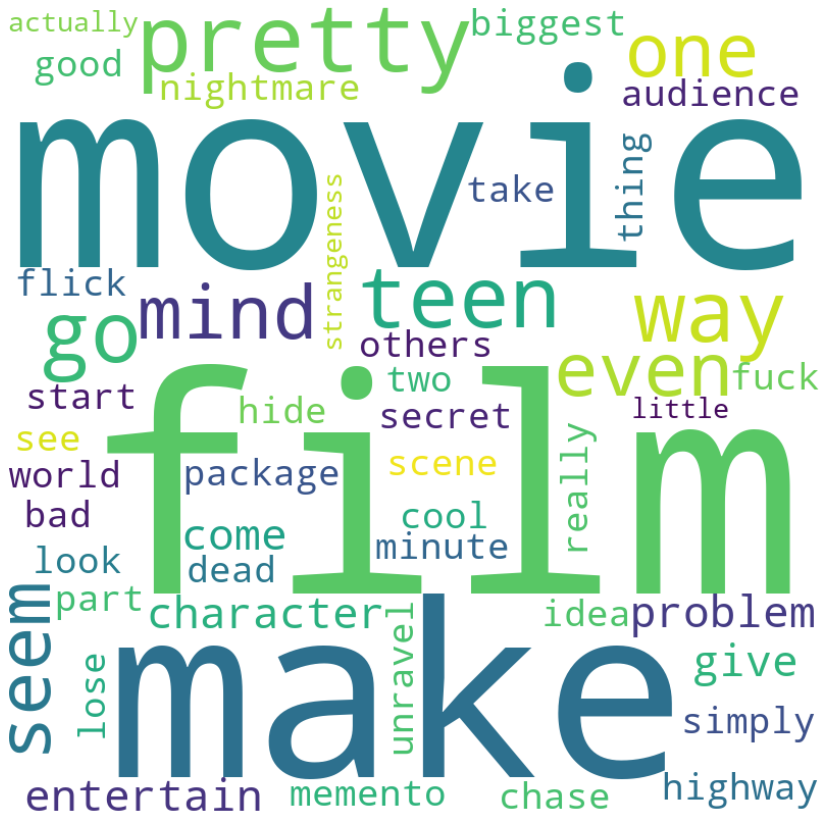

In [19]:
# Word Cloud /// Part B.3 

file_number = 0
show_word_cloud(words_list,file_number)

In [15]:
# Creating TF-IDF with max_features = 50
tfidf_model, tfidf_df = tf_idf(words_list,max_fea = 50)

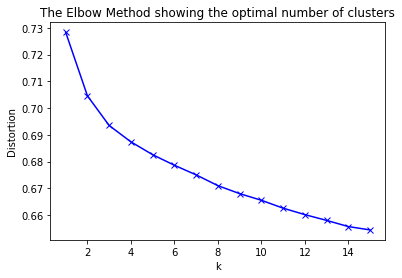

In [124]:
#Elbow Method

plot_elbow(tfidf_df,15)

# # In fact, it would be more correct to choose one of the values 3,4,5 here, but since it does not overlap with our target values, we will proceed by choosing 2.

In [16]:
#Create K_means Model and Dataframe with TFIDF

kmeans_df , kmeans_model = k_means(tfidf_df,2)
kmeans_df.head(10)

,Text,Target,predicted
0,plot two teen couple go church party drink dri...,0,1
1,happy bastard quick movie review damn y2k bug ...,0,1
2,movie like make jade movie viewer thankful inv...,0,0
3,quest camelot warner bros first feature length...,0,0
4,synopsis mentally unstable man undergo psychot...,0,1
5,capsule 2176 planet mar police take custody ac...,0,0
6,ask 8mm eight millimeter really wholesome surv...,0,0
7,exactly long movie felt even nine laugh nine m...,0,1
8,call road trip walk wound stellan skarsg rd pl...,0,0
9,plot young french boy see parent kill eye tim ...,0,1


In [126]:
#Create Logistic Regression Model and Dataframe with TFIDF

logreg_df , logreg_model = log_reg(tfidf_df,words_list)
logreg_df.head(10)

,Text,Target,predicted
0,plot two teen couple go church party drink dri...,0,0
1,happy bastard quick movie review damn y2k bug ...,0,0
2,movie like make jade movie viewer thankful inv...,0,0
3,quest camelot warner bros first feature length...,0,0
4,synopsis mentally unstable man undergo psychot...,0,0
5,capsule 2176 planet mar police take custody ac...,0,1
6,ask 8mm eight millimeter really wholesome surv...,0,1
7,exactly long movie felt even nine laugh nine m...,0,0
8,call road trip walk wound stellan skarsg rd pl...,0,0
9,plot young french boy see parent kill eye tim ...,0,0


In [127]:
#Create Lineer Regression Model and Dataframe with TFIDF

linreg_df , linreg_model = lin_reg(tfidf_df,words_list)
linreg_df.tail(10)

,Text,Target,predicted,predicted_datas
1990,relax dude rid roller coaster big lebowski fil...,1,0,0.448835
1991,box kid glove play nice nice guy never ever go...,1,1,0.630889
1992,film unexpected scary original catch guard thr...,1,1,0.734766
1993,plot movie take place one day rookie cop narco...,1,1,0.562537
1994,thriller set modern day seattle mark marky mar...,1,1,0.535106
1995,wow movie everything movie funny dramatic inte...,1,1,0.729881
1996,richard gere command actor always great film e...,1,1,0.501214
1997,glory star matthew broderick denzel washington...,1,0,0.375371
1998,steven spielberg second epic film world war ii...,1,1,0.644067
1999,truman true man burbank perfect name jim carre...,1,1,0.833670


In [128]:
#Create XGB Model and Dataframe with TFIDF

xgb_df, xgb_model = XGB(tfidf_df,words_list)
xgb_df.head(10)

,Text,Target,predicted
0,plot two teen couple go church party drink dri...,0,0
1,happy bastard quick movie review damn y2k bug ...,0,0
2,movie like make jade movie viewer thankful inv...,0,0
3,quest camelot warner bros first feature length...,0,0
4,synopsis mentally unstable man undergo psychot...,0,0
5,capsule 2176 planet mar police take custody ac...,0,0
6,ask 8mm eight millimeter really wholesome surv...,0,1
7,exactly long movie felt even nine laugh nine m...,0,0
8,call road trip walk wound stellan skarsg rd pl...,0,0
9,plot young french boy see parent kill eye tim ...,0,0


K-Means
Accuracy : %42.75
Precision: 0.41
F1 Score : 0.38
Root Mean Squared Error : 0.76


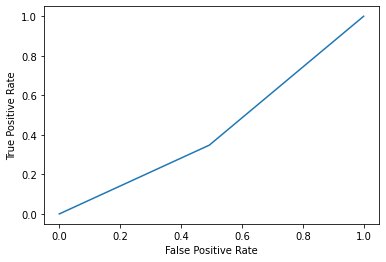

predicted,0,1
Target,,
0,507,493
1,652,348


In [17]:
# Showing K-Means Results
print('K-Means')
kmeans_tab = pd.crosstab(kmeans_df['Target'], kmeans_df['predicted'])
show_accuracy(kmeans_tab)
show_pre(kmeans_tab)
show_f1_score(kmeans_tab)
show_rmse(kmeans_df)
plot_roc(kmeans_df,kmeans_model,tfidf_df)
kmeans_tab

Linear Regression
Accuracy : %73.15
Precision: 0.72
F1 Score : 0.74
Root Mean Squared Error : 0.52


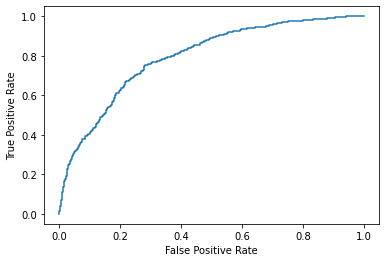

predicted,0,1
Target,,
0,705,295
1,242,758


In [150]:
# Showing Linear Regression Results
print('Linear Regression')
linreg_tab = pd.crosstab(linreg_df['Target'], linreg_df['predicted'])
show_accuracy(linreg_tab)
show_pre(linreg_tab)
show_f1_score(linreg_tab)
show_rmse(linreg_df)
plot_roc(linreg_df,linreg_model,tfidf_df)
linreg_tab

Logistic Regression
Accuracy : %72.60
Precision: 0.72
F1 Score : 0.73
Root Mean Squared Error : 0.52


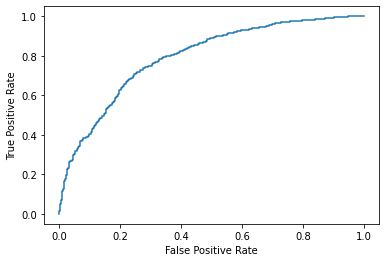

predicted,0,1
Target,,
0,706,294
1,254,746


In [151]:
# Showing Logistic Regression Results
print('Logistic Regression')
logreg_tab = pd.crosstab(logreg_df['Target'], logreg_df['predicted'])
show_accuracy(logreg_tab)
show_pre(logreg_tab)
show_f1_score(logreg_tab)
show_rmse(logreg_df)
plot_roc_lor(logreg_df,logreg_model,tfidf_df)
logreg_tab

XGBoost
Accuracy : %75.65
Precision: 0.75
F1 Score : 0.76
Root Mean Squared Error : 0.49


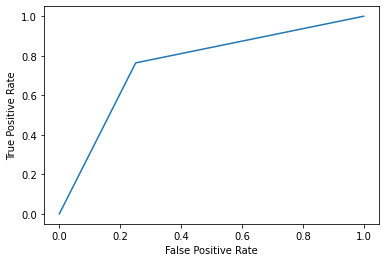

predicted,0,1
Target,,
0,749,251
1,236,764


In [136]:
# Showing XGBoost Results
print('XGBoost')
xgb_tab = pd.crosstab(xgb_df['Target'], xgb_df['predicted'])
show_accuracy(xgb_tab)
show_pre(xgb_tab)
show_f1_score(xgb_tab)
show_rmse(xgb_df)
plot_roc(xgb_df, xgb_model, tfidf_df)
xgb_tab

In [102]:
#### If we want to print fingerprints of file   


# def topic_vector(topic_model:LdaModel, text:str):
#     fingerprint = [0] * topic_model.num_topics
#     for topic, prob in topic_model[dictionary.doc2bow(text)]:
#         fingerprint[topic] = prob
#     return fingerprint
# 
# def show_fingerprint(topic_model, text:str):
#     #display(text)
#     vector = topic_vector(topic_model, text)
#     plt.figure(figsize=(8,1))
#     ax = plt.bar( range(len(vector)),vector,0.25,linewidth=1)
#     plt.ylim(top=0.4)
#     plt.tick_params(axis='both',which='both',left=False,bottom=False,top=False,labelleft=True,labelbottom=True)
#     plt.grid(False)
# 
# out
# style.use('fivethirtyeight')
# VECTOR_SIZE=100
# %matplotlib inline
# show_fingerprint(lda_model, words_list[0])

In [13]:
# Creating LDA model and showing relevance values
word_dic , corpus = get_corpus(words_list)
lda_model , rel_df = lda(corpus,words_list,word_dic)
rel_df.sort_values(by=['Relevance'], inplace=True, ascending=False)
rel_df.head(10)

,Relevance
Topic,
43,0.477665
32,0.125897
86,0.061152
82,0.047508
57,0.025856
29,0.021423
95,0.020913
78,0.017571
35,0.015155


In [ ]:
# from sklearn.cluster import MiniBatchKMeans
# K = range(1,15)
# SSE = []
# for k in K:
#     kmeans = MiniBatchKMeans(n_clusters = k,batch_size = 300)
#     kmeans.fit(tfidf_df)
#     SSE.append(kmeans.inertia_)
    
# import matplotlib.pyplot as plt
# plt.plot(K,SSE,'bx-')
# plt.title('Elbow Method')
# plt.xlabel('cluster numbers')
# plt.show()

# We chose topic number according to number of relevance that is greater than 0.1

In [16]:
# Printing LDA Topics
print('LDA Topics:')
lda_topics = show_topics_lda(words_list, topic_number = 2, word_number = 10)

LDA Topics:
['film', 'movie', 'one', 'make', 'like', 'get', 'character', 'see', 'go', 'time']
['film', 'one', 'movie', 'make', 'character', 'like', 'go', 'time', 'get', 'see']


In [17]:
# Printing K-Means Topics
from sklearn.cluster import MiniBatchKMeans
print('K_Means Topics:')
kmeans_topics = show_topics_kmeans(tfidf_model,tfidf_df, topic_number = 2, word_number = 10)

K_Means Topics:
['movie', 'one', 'film', 'get', 'like', 'make', 'character', 'see', 'go', 'time']
['film', 'one', 'make', 'character', 'like', 'scene', 'get', 'time', 'movie', 'go']


In [18]:
# Showing similarity between model's topics
acc_list = []-
for i in range(len(kmeans_topics)):
    acc = len(set(lda_topics[i]) & set(kmeans_topics[i])) / 10 
    acc_list.append(acc)
print('Similarity Accuracy:')
acc_list

Similarity Accuracy:


[1.0, 0.9]